## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Using data with wrap instead of border_reflect_101 and imgaug to add classes

Note we dont use aug on irregular metal

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_wrap'

In [10]:
NB_NUM='05_2'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 9541a117, DATE: 20191029


In [12]:
DATE ='20191028'
UID='77dc216d'

In [13]:
SUB_NUM='3'

In [14]:
img_size=256

In [15]:
train_images=data_dir/f'train/rotated/wrap/{img_size}'
test_images=data_dir/f'test/rotated/wrap/{img_size}'

In [16]:
test_names = get_image_files(test_images)

In [17]:
assert len(test_names)==7325

In [18]:
df_all=pd.read_csv(data_dir/'df_aug_wrap.csv')

In [19]:
df_all.tail()

,id,roof_material,verified,country,region
61228,7a3d40e2_imgaug_0_589,irregular_metal,True,colombia,borde_rural
61229,7a41538a_imgaug_1_555,irregular_metal,True,colombia,borde_rural
61230,7a28b708_imgaug_2_4114,irregular_metal,True,colombia,borde_soacha
61231,7a2f3042_imgaug_1_1290,incomplete,True,colombia,borde_rural
61232,7a2c65ce_imgaug_1_7114,irregular_metal,True,guatemala,mixco_1_and_ebenezer


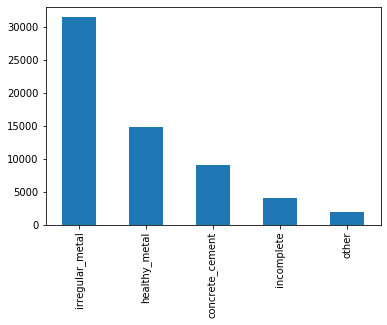

In [20]:
df_all['roof_material'].value_counts().plot(kind='bar')

In [21]:
df_img=df_all[df_all.id.str.contains('imgaug')]

In [22]:
df_img=df_img.loc[df_img['roof_material'] == 'irregular_metal']

In [23]:
aug_ids=df_img.index.tolist()

In [24]:
df_all_aug=df_all.drop(aug_ids)

In [25]:
len(df_all_aug)

35028

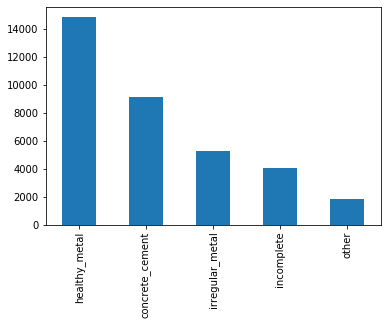

In [26]:
df_all_aug['roof_material'].value_counts().plot(kind='bar')

In [27]:
df_all=df_all_aug

In [28]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [29]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [30]:
assert len(df_test)==7325

In [31]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [32]:
len(df_all)

35028

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [33]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [34]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [35]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [36]:
#to check what params object has
#dir(data)

In [37]:
data.label_list

LabelLists;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256

In [38]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

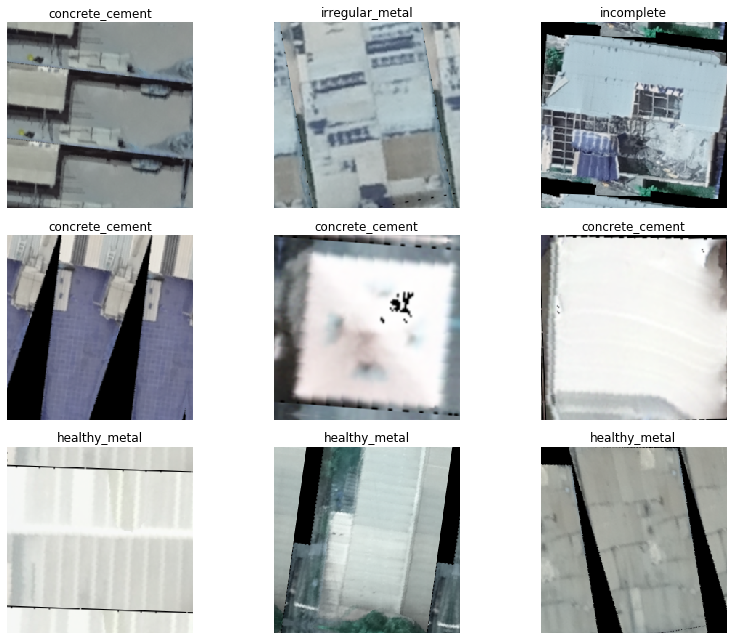

In [39]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [40]:
arch = models.resnet50
arch_name = 'rn50'

In [41]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [49]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


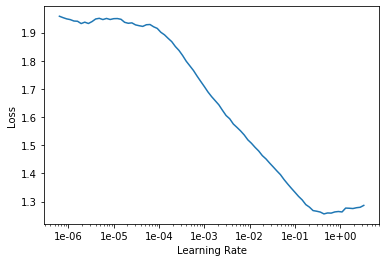

In [51]:
learn.recorder.plot()

Then we can fit the head of our network.

In [52]:
lr = 1e-2

In [53]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.621937,0.547340,0.204854,01:31
1,0.461298,0.476308,0.181727,01:30
2,0.408277,0.423520,0.162455,01:30
3,0.363399,0.383214,0.147323,01:31
4,0.322902,0.375154,0.144468,01:31


In [ ]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [39]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (48987 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (12246 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,healthy_metal,healthy_metal,healthy_metal,incomplete
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequenti

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 345),
 ('incomplete', 'irregular_metal', 340),
 ('healthy_metal', 'irregular_metal', 201),
 ('other', 'healthy_metal', 140),
 ('concrete_cement', 'healthy_metal', 98),
 ('incomplete', 'concrete_cement', 97),
 ('irregular_metal', 'concrete_cement', 78),
 ('irregular_metal', 'incomplete', 78),
 ('concrete_cement', 'irregular_metal', 76),
 ('other', 'irregular_metal', 47),
 ('concrete_cement', 'incomplete', 30),
 ('incomplete', 'healthy_metal', 23),
 ('healthy_metal', 'concrete_cement', 19),
 ('irregular_metal', 'other', 12),
 ('other', 'concrete_cement', 9),
 ('healthy_metal', 'incomplete', 3),
 ('healthy_metal', 'other', 3),
 ('incomplete', 'other', 3)]

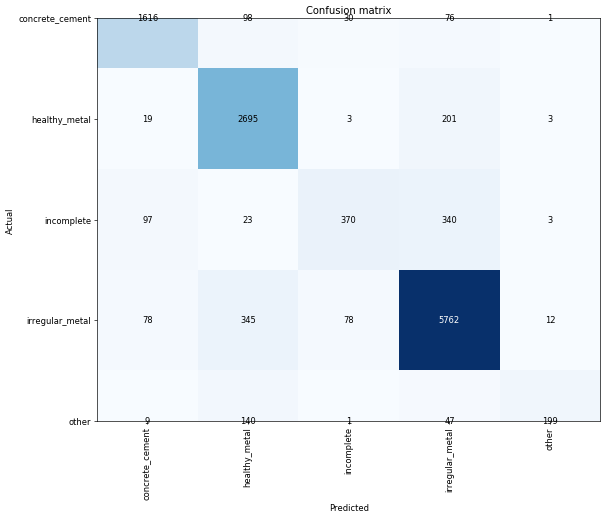

In [41]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


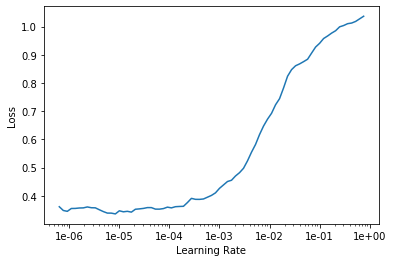

In [43]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.336073,0.378879,0.147323,01:30
1,0.322865,0.370061,0.143183,01:31
2,0.311782,0.361173,0.139900,01:31
3,0.303201,0.347177,0.135046,01:31
4,0.299865,0.334215,0.128337,01:31


In [55]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [56]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Se

In [57]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.291217,0.343528,0.132049,01:42
1,0.300605,0.328598,0.125482,01:46
2,0.284269,0.337443,0.127195,01:49
3,0.294673,0.325531,0.124340,01:48
4,0.265335,0.325966,0.124625,01:48


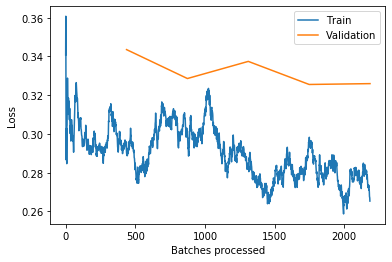

In [58]:
learn.recorder.plot_losses()

In [59]:
learn.save(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### fp32

In [42]:
learn.load(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Se

In [43]:
learn = learn.to_fp32()

In [44]:
learn.export(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [45]:
learn.export()

### inference

In [51]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [52]:
len(test_dataset)

7325

In [53]:
#learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [54]:
#learn.load(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [55]:
#learn.get_preds(ds_type=DatasetType.Test)

In [56]:
learn = load_learner(path=data_dir/f'train/rotated/wrap/{img_size}', test=test_dataset)

In [57]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [58]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [59]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [60]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [61]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [62]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [63]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [64]:
labels = np.argmax(preds, 1)

In [65]:
len(preds)

7325

In [66]:
preds[0].tolist()

[0.010082573629915714,
 0.98423171043396,
 0.0014650400262326002,
 0.002680498640984297,
 0.0015400891425088048]

In [67]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [68]:
len(labels)

7325

In [69]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [70]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [71]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [72]:
test_predictions[0]

'healthy_metal'

In [73]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [74]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/wrap/256/7a4d9168.tif'), PosixPath('data/test/rotated/wrap/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/wrap/256/7a48ca98.tif'), PosixPath('data/test/rotated/wrap/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/wrap/256/7a486800.tif'), PosixPath('data/test/rotated/wrap/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/wrap/256/7a501f50.tif'), PosixPath('data/test/rotated/wrap/256/7a4d27b4.tif')],
      dtype=object)

In [75]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [76]:
preds_list[0]

[0.010082573629915714,
 0.98423171043396,
 0.0014650400262326002,
 0.002680498640984297,
 0.0015400891425088048]

In [77]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [78]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [79]:
df.head()

,id,pred
0,7a4d9168,"[0.010082573629915714, 0.98423171043396, 0.001..."
1,7a4ae922,"[0.045268118381500244, 0.8800477385520935, 0.0..."
2,7a48ca98,"[0.0036645089276134968, 0.16889479756355286, 0..."
3,7a49c614,"[0.0009695130283944309, 0.7965055704116821, 0...."
4,7a4dd4f2,"[0.0027714408934116364, 0.9517889618873596, 0...."


In [80]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [81]:
pred_df.insert(loc=0, column='id', value=ids)

In [82]:
pred_df.columns = cols

In [83]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.010083,0.984232,0.001465,0.002680,0.001540
1,7a4ae922,0.045268,0.880048,0.001325,0.071674,0.001685
2,7a48ca98,0.003665,0.168895,0.006338,0.819745,0.001357
3,7a49c614,0.000970,0.796506,0.002291,0.198652,0.001582
4,7a4dd4f2,0.002771,0.951789,0.001492,0.034927,0.009021


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [84]:
#pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [85]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.010083,0.984232,0.001465,0.002680,0.001540
1,7a4ae922,0.045268,0.880048,0.001325,0.071674,0.001685
2,7a48ca98,0.003665,0.168895,0.006338,0.819745,0.001357
3,7a49c614,0.000970,0.796506,0.002291,0.198652,0.001582
4,7a4dd4f2,0.002771,0.951789,0.001492,0.034927,0.009021


In [86]:
pred_ids=pred_df['id'].values.tolist()

In [87]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [88]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [89]:
baseline_ids=df_baseline['id'].values.tolist()

In [90]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [91]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [92]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [93]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.010083,0.984232,0.001465,0.002680,0.001540,7a4d9168
1,7a4ae922,0.045268,0.880048,0.001325,0.071674,0.001685,7a4ae922
2,7a48ca98,0.003665,0.168895,0.006338,0.819745,0.001357,7a48ca98
3,7a49c614,0.000970,0.796506,0.002291,0.198652,0.001582,7a49c614
4,7a4dd4f2,0.002771,0.951789,0.001492,0.034927,0.009021,7a4dd4f2


In [94]:
pred_df=pred_df.sort_values('id_cat')

In [95]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.003078,0.981060,0.001451,0.013907,0.000504,7a4d630a
764,7a4bbbd6,0.002233,0.956362,0.005062,0.034908,0.001435,7a4bbbd6
1841,7a4ac744,0.004239,0.863095,0.016471,0.112301,0.003894,7a4ac744
3363,7a4881fa,0.002227,0.076019,0.001422,0.919924,0.000407,7a4881fa
133,7a4aa4a8,0.004680,0.893022,0.006255,0.093815,0.002227,7a4aa4a8


In [96]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [97]:
assert (len(pred_df))==7325

In [98]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### submission 5: score 0.4890